<a href="https://colab.research.google.com/github/Zeinebhajr/Video-Reconstruction/blob/main/VideoProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Architecture

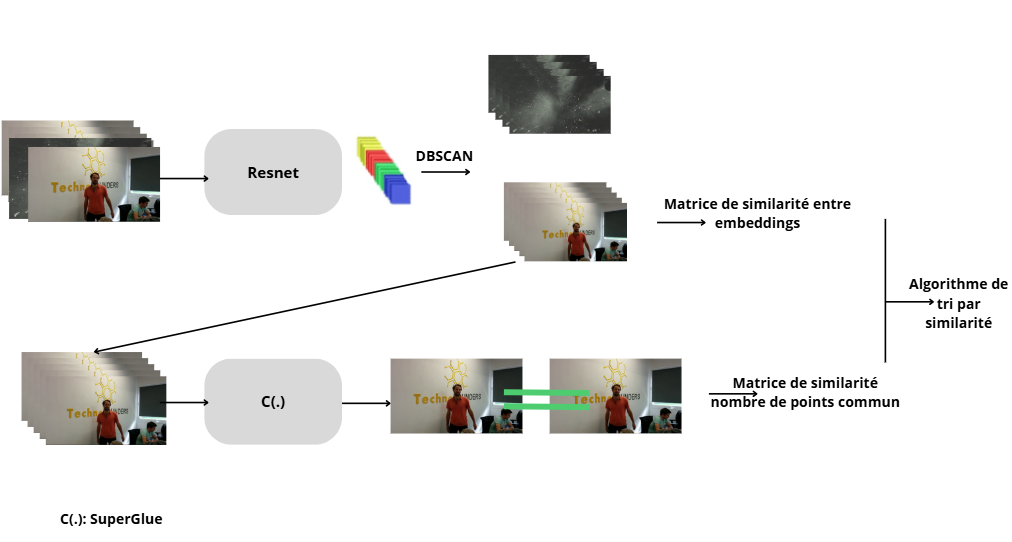

#Installation des librairies

##Cloner le répo SuperGlue

In [1]:
!git clone https://github.com/magicleap/SuperGluePretrainedNetwork.git

Cloning into 'SuperGluePretrainedNetwork'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 185 (delta 0), reused 2 (delta 0), pack-reused 182 (from 1)
Receiving objects: 100% (185/185), 118.85 MiB | 15.22 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [2]:
!pip install -r /content/SuperGluePretrainedNetwork/requirements.txt

ERROR: Ignored the following yanked versions: 3.4.11.39, 3.4.17.61, 4.4.0.42, 4.4.0.44, 4.5.4.58, 4.5.5.62, 4.7.0.68
ERROR: Could not find a version that satisfies the requirement opencv-python==4.1.2.30 (from versions: 3.4.0.14, 3.4.10.37, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.57, 3.4.16.59, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.60, 4.5.5.64, 4.6.0.66, 4.7.0.72, 4.8.0.74, 4.8.0.76, 4.8.1.78, 4.9.0.80, 4.10.0.82, 4.10.0.84)
ERROR: No matching distribution found for opencv-python==4.1.2.30


In [3]:
!wget -P /content/SuperGluePretrainedNetwork/models/ https://github.com/magicleap/SuperGluePretrainedNetwork/blob/master/models/weights/superglue_indoor.pth

--2024-12-17 16:20:24--  https://github.com/magicleap/SuperGluePretrainedNetwork/blob/master/models/weights/superglue_indoor.pth
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘/content/SuperGluePretrainedNetwork/models/superglue_indoor.pth’

superglue_indoor.pt     [ <=>                ] 165.57K  --.-KB/s    in 0.01s   

2024-12-17 16:20:24 (15.0 MB/s) - ‘/content/SuperGluePretrainedNetwork/models/superglue_indoor.pth’ saved [169544]



In [4]:
import sys
sys.path.append('/content/SuperGluePretrainedNetwork')

##Importer les librairies

In [5]:
!pip install kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.4/899.4 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.1 MB/s eta 0:00:00


In [6]:
import cv2
import torch
import torchvision.transforms as transforms
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from models.matching import Matching  # Assuming you have the Matching class correctly defined
import kornia as K

#Elimination des images outliers

#Resnet

Extraction des features des images grace à Resnet

In [7]:
def extract_frame_embeddings(video_path, model, transform, device="gpu"):
    """
    Extract frame embeddings using a pre-trained model.

    Args:
        video_path (str): Path to the video file.
        model (torch.nn.Module): Pre-trained PyTorch model.
        transform (torchvision.transforms.Compose): Transformations for model input.
        device (str): Device for computation ('cpu' or 'cuda').

    Returns:
        embeddings (list): List of frame embeddings.
        frame_indices (list): List of frame indices corresponding to embeddings.
    """
    cap = cv2.VideoCapture(video_path)
    embeddings = []
    frame_indices = []
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Resize and normalize the frame
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        img_tensor = transform(img).unsqueeze(0).to(device)

        # Extract embedding
        with torch.no_grad():
            embedding = model(img_tensor).squeeze().cpu().numpy()
            embeddings.append(embedding)
            frame_indices.append(frame_idx)

        frame_idx += 1

    cap.release()
    return embeddings, frame_indices

##Classification du type d'image avec DBSCAN

In [8]:
def detect_outliers_with_dbscan(embeddings, eps=0.5, min_samples=5):
    """
    Detect outlier frames using DBSCAN clustering.

    Args:
        embeddings (list): List of frame embeddings.
        eps (float): Maximum distance between points in a cluster.
        min_samples (int): Minimum number of points in a cluster.

    Returns:
        outlier_indices (list): Indices of outlier frames.
    """
    embeddings = np.array(embeddings)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(embeddings)
    labels = clustering.labels_

    # Outliers are labeled as -1 in DBSCAN
    outlier_indices = [i for i, label in enumerate(labels) if label == -1]
    return outlier_indices

Obtention de la video sans outliers

In [9]:
video_path = "/content/corrupted_video.mp4"

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model = model.eval().to(device)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

embeddings, frame_indices = extract_frame_embeddings(video_path, model, transform, device)
outlier_indices = detect_outliers_with_dbscan(embeddings, eps=5.5, min_samples=2)
cap=cv2.VideoCapture(video_path)
height, width= 1080 , 1920
out = cv2.VideoWriter("video_pure.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 25, (width, height))
i=0
while cap.isOpened():
  ret,frame=cap.read()
  if not ret:
    break
  if i not in outlier_indices:
    out.write(frame)
  i+=1
out.release()
vid='video_pure.mp4'

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


#Reordonnecement des frames

Matrice de similitudes des features  globaux


In [11]:
def compute_similarity_matrix(embeddings):
    """Compute pairwise cosine similarity for embeddings."""
    return cosine_similarity(embeddings)


Matrice de similarités des points d'interets

In [12]:
import torch
import cv2
import numpy as np

class CorrespondenceExtractor:
    def __init__(self, device, resize=640, descriptor_size=256, weight_similarity=0.5):
        self.device = device
        self.resize = resize
        self.descriptor_size = descriptor_size  # Fixed descriptor size
        self.weight_similarity = weight_similarity  # Weight for combining similarity matrices

        # Initialize SuperPoint and SuperGlue parameters
        superpoint_params = {
            'nms_radius': 4,
            'keypoint_threshold': 0.005,
            'max_keypoints': 1024
        }
        superglue_params = {
            'weights': 'indoor',
            'sinkhorn_iterations': 20,
            'match_threshold': 0.2
        }

        # Instantiate the SuperGlue model using the Matching class
        self.matching_model = Matching({
            'superpoint': superpoint_params,
            'superglue': superglue_params
        }).eval().to(self.device)

    def extract_correspondences(self, prev_frame, curr_frame):
        """Extract corresponding keypoints and descriptors between two frames."""
        prev_tensor = self._preprocess_frame(prev_frame)
        curr_tensor = self._preprocess_frame(curr_frame)

        with torch.no_grad():
            predictions = self.matching_model({
                'image0': prev_tensor,
                'image1': curr_tensor
            })

        keypoints0, keypoints1, matches, scores = self._extract_matches(predictions)
        descriptors0 = predictions['descriptors0'][0].cpu().numpy()
        descriptors1 = predictions['descriptors1'][0].cpu().numpy()

        return keypoints0, keypoints1, matches, scores, descriptors0, descriptors1

    def _preprocess_frame(self, frame):
        """Convert frame to grayscale, resize, and normalize for SuperGlue."""
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        tensor = torch.from_numpy(gray_frame).unsqueeze(0).unsqueeze(0).float().to(self.device) / 255.0
        resize_transform = K.augmentation.Resize(self.resize, side="long")
        return resize_transform(tensor)

    def _extract_matches(self, predictions):
        """Extract keypoints, matches, and scores from SuperGlue predictions."""
        keypoints0 = predictions['keypoints0'][0].cpu().numpy()
        keypoints1 = predictions['keypoints1'][0].cpu().numpy()
        matches = predictions['matches0'][0].cpu().numpy()
        scores = predictions['matching_scores0'][0].cpu().numpy()
        valid = matches > -1
        matched_keypoints0 = keypoints0[valid]
        matched_keypoints1 = keypoints1[matches[valid]]
        return matched_keypoints0, matched_keypoints1, matches, scores

# Function to compute the similarity matrix based on the number of matches
def compute_match_similarity(video_frames, correspondence_extractor):
    """Compute similarity based on the number of matches using SuperGlue."""
    n_frames = len(video_frames)
    match_similarity_matrix = np.zeros((n_frames, n_frames))

    for i in range(n_frames):
        for j in range(i + 1, n_frames):
            frame1 = video_frames[i]
            frame2 = video_frames[j]

            # Extract correspondences using CorrespondenceExtractor
            keypoints0, keypoints1, matches, scores, descriptors0, descriptors1 = correspondence_extractor.extract_correspondences(frame1, frame2)

            # Count number of valid matches
            num_matches = np.sum(matches > -1)  # Count number of valid matches

            # Assign similarity based on the number of matches
            similarity = num_matches / len(matches)  # Normalize the similarity
            match_similarity_matrix[i, j] = similarity
            match_similarity_matrix[j, i] = similarity  # Symmetric matrix

    return match_similarity_matrix

# Load the video and extract frames
def load_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    video_frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Convert frame from BGR (OpenCV format) to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        video_frames.append(frame_rgb)
    cap.release()

    return video_frames

# Main function to process the video and compute final similarity matrix
def main(video_path, correspondence_extractor):
    # Load video frames
    video_frames = load_video_frames(video_path)

    # Compute similarity matrix based on SuperGlue matches
    match_similarity_matrix = compute_match_similarity(video_frames, correspondence_extractor)

    return match_similarity_matrix

# Example usage
if __name__ == "__main__":
    video_path = vid

    correspondence_extractor = CorrespondenceExtractor(device='cuda')

    # Process the video and compute the similarity matrix
    final_similarity_matrix = main(video_path, correspondence_extractor)

    print("Final similarity matrix:")
    print(final_similarity_matrix)


/content/SuperGluePretrainedNetwork/models/superpoint.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(str(path)))
/content/SuperGluePre

Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-9b6fcece8589>", line 122, in <cell line: 116>
    final_similarity_matrix = main(video_path, correspondence_extractor)
  File "<ipython-input-12-9b6fcece8589>", line 111, in main
    match_similarity_matrix = compute_match_similarity(video_frames, correspondence_extractor)
  File "<ipython-input-12-9b6fcece8589>", line 77, in compute_match_similarity
    keypoints0, keypoints1, matches, scores, descriptors0, descriptors1 = correspondence_extractor.extract_correspondences(frame1, frame2)
  File "<ipython-input-12-9b6fcece8589>", line 36, in extract_correspondences
    predictions = self.matching_model({
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/lo


KeyboardInterrupt



jointure des 2 matrices

In [ ]:
def join_similarities(similarity_embeddings,similarity_keypoints,alpha):
  return alpha * similarity_keypoints + (1 - alpha) * similarity_embeddings


algo ordonner

In [ ]:
def reorder_frames_by_similarity(similarity_matrix):
    """Reorder frames using nearest neighbor chaining based on similarity."""
    n_frames = similarity_matrix.shape[0]
    # Start with the most central frame
    central_frame = np.argmax(np.mean(similarity_matrix, axis=1))
    ordered_indices = [central_frame]
    visited = set(ordered_indices)

    while len(ordered_indices) < n_frames:
        last_frame = ordered_indices[-1]
        # Find the most similar unvisited frame
        next_frame = np.argmax(similarity_matrix[last_frame])
        while next_frame in visited:
            similarity_matrix[last_frame, next_frame] = -1  # Mark as visited
            next_frame = np.argmax(similarity_matrix[last_frame])
        ordered_indices.append(next_frame)
        visited.add(next_frame)

    return ordered_indices


enregistrer la video

In [ ]:
def save_reordered_video(video_path, frame_order, output_path):
    """Save reordered video based on frame order."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    print(len(frames))
    # Reorder frames
    reordered_frames = [frames[i] for i in frame_order]

    # Save reordered video
    height, width, layers = reordered_frames[0].shape
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), 25, (width, height))
    for frame in reordered_frames:
        out.write(frame)
    out.release()

finalement

**Combinaison des matrices de similarité :**
La nouvelle version utilise une combinaison linéaire pondérée entre la matrice de similarité des embeddings (ResNet) et celle des keypoints (SuperGlue). La combinaison est définie comme :

*similarity_combined
=
𝛼
×
similarity_embeddings
+
(
1
−
𝛼
)
×
similarity_keypoints*


*similarity_combined=α×similarity_embeddings+(1−α)×similarity_keypoints
où
𝛼
∈
[
0
,
1
]
α∈[0,1].*

**Robustesse face aux incohérences** :

Si alpha = 1, seule la matrice des embeddings est utilisée (résultat homogène mais incohérences temporelles possibles).
Si alpha = 0, seule la matrice des keypoints est utilisée (cohérence temporelle mais risque de "lags").
Vous pouvez expérimenter différentes valeurs de
𝛼
α pour trouver un équilibre adapté à votre vidéo.

In [ ]:
embeddings, frame_indices = extract_frame_embeddings(vid, model, transform, device)
normalized_embeddings = normalize(embeddings)
similarity_embeddings = compute_similarity_matrix(embeddings)
matrix=np.eye(final_similarity_matrix.shape[0])-final_similarity_matrix
sim_totale=join_similarities(similarity_embeddings,matrix,0.9)
ordered_indices = reorder_frames_by_similarity(sim_totale)
save_reordered_video(vid, ordered_indices, 'reordered_video.mp4')